In [1]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context(context='poster')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.monospace'] = 'Andale Mono'
# mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.default'] = 'rm'

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
]

bigsize   = 20
midsize   = 20
smallsize = 15
# hugesize  = 24

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from tqdm.auto import tqdm
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde

In [ ]:
from figdata import ref, sum_df, big_cnv_cells, big_cnv_idx, sample_colors, xlsx_tab, good_df

In [5]:
FSAMPLE = True
FSAMPLE = False

In [10]:
# model2 = TSNE( n_components=2, random_state=0, init='pca' )

# rd_data_list = []
# for g,df in tqdm(big_cnv_matrix.groupby('space')):
#     df = df.T.drop('space').rolling(20, axis=1).median().dropna(how='all', axis=1)

#     n = df.shape[0]//50
#     model1 = MDS( n_components=n, random_state=0 )
#     rd_data1 = pd.DataFrame( model1.fit_transform( df ) ).set_index(df.index)
#     rd_data_list.append(rd_data1)

# rd_data1 = pd.concat(rd_data_list, axis=1)
# rd_data2 = pd.DataFrame( model2.fit_transform( rd_data1 ), index=rd_data1.index, columns=['tSNE1','tSNE2']  )

# matrix_2d = rd_data2.copy()

# matrix_2d.to_pickle('matrix_2d.pkl')

matrix_2d = pd.read_pickle('matrix_2d.pkl')

In [11]:
cell_info = pd.concat(
    [
        sum_df.loc[big_cnv_idx].groupby(['Cell','Chromosome','cnvTag'])['Gender'].first(),
        sum_df.loc[big_cnv_idx].groupby(['Cell','Chromosome','cnvTag'])['Sample'].first(),
        sum_df.loc[big_cnv_idx].groupby(['Cell','Chromosome','cnvTag'])['chrom_fraction'].max(),
    ], axis=1
).reset_index().set_index('Cell')

cell_info['Age'] = cell_info['Sample'].replace(xlsx_tab.set_index('SAMPLE')['AGE'].to_dict())

matrix_2d = pd.merge(
    matrix_2d, cell_info, 
    right_index=True, left_index=True,
    how='left',
)

matrix_2d['Whole'] = 'False'
matrix_2d['Whole'] = matrix_2d.where(matrix_2d['chrom_fraction']<80, other='True')['Whole']

In [12]:
two_colors = sns.xkcd_palette(['bright blue','red'])

matrax_colors = {
    'male'   : two_colors[0],
    'female' : two_colors[1],
    'True'   : 'coral',
    'False'  : 'violet',
    'Gain'   : 'darkorange', 
    'Loss'   : 'deepskyblue',
}
matrax_colors.update( 
    dict( 
        zip( 
            xlsx_tab['SAMPLE'], 
            sample_colors, 
        ) 
    ) 
)
matrax_colors.update( 
    dict( 
        zip( 
            ref['space'].unique(), 
            sns.color_palette('rainbow',24) 
#             sns.color_palette('gnuplot2',24) 
        ) 
    ) 
)
matrax_colors.update( 
    dict( 
        zip(
            xlsx_tab['AGE'], 
            xlsx_tab['AGE'].apply( 
                lambda r: plt.get_cmap('gray')(
                    Normalize(-1, 82)(r)
                ) 
            )
        ) 
    ) 
)

if not FSAMPLE:
    matrax_colors['XXX'] = matrax_colors['$FSAMPLE']


In [13]:
def add_sample_legend(ax):
    handles, labels = ax.get_legend_handles_labels()

    h1s = np.array(
        handles
    )[
        xlsx_tab
        .set_index('SAMPLE')
        .loc[labels]
        .reset_index().reset_index()
        .set_index('CODE')
#         .loc[xlsx_tab.query('GENDER=="male"')['CODE'],'index'].dropna().astype(int)
        .reindex(index=xlsx_tab.query('GENDER=="male"')['CODE'])['index'].dropna().astype(int)
        .values
    ]

    h2s = np.array(
        handles
    )[
        xlsx_tab
        .set_index('SAMPLE')
        .loc[labels]
        .reset_index().reset_index()
        .set_index('CODE')
        .loc[xlsx_tab.query('GENDER=="female"')['CODE'],'index']
        .values
    ]

    lg1 = ax.legend(
        h1s,
        map(lambda x:'{:02d}'.format(x), np.arange(1,h1s.shape[0]+1)),
        loc='upper left',
        title='M',
        prop={'size':smallsize},
        handletextpad=-0.5,
        columnspacing=-0.5,
        labelspacing=0,
        edgecolor='k',
        ncol=3,
        markerfirst=False,
    )

    lg1.get_title().set_fontsize(smallsize)

    for h in lg1.legendHandles: 
        h.set_alpha(0.9)
        h.set_sizes([50])

    ax.add_artist(lg1)

    lg2 = ax.legend(
        h2s,
        map(lambda x:'{:02d}'.format(x), np.arange(1,h2s.shape[0]+1)),
        loc='upper right',
        title='F',
        prop={'size':smallsize},
        handletextpad=-0.5,
        columnspacing=-0.5,
        labelspacing=0,
        edgecolor='k',
        ncol=3,
        markerfirst=False,
        borderpad=0.2,
    )

    lg2.get_title().set_fontsize(smallsize)

    for h in lg2.legendHandles: 
        h.set_alpha(0.9)
        h.set_sizes([50])

In [14]:
def add_chroms_legend(ax):
    handles, labels = ax.get_legend_handles_labels()

    hs = np.array(
        handles,
    #     labels,
    )[
        pd.DataFrame(labels)
        .reset_index()
        .set_index(0)
        .loc[ref['space'].unique()[:-1],'index']
        .values
    ]

    ax.legend(
        hs,
        np.arange(1,23).tolist() + ['X'],
        loc='upper left',
        prop={'size':smallsize},
        handletextpad=-0.5,
        columnspacing=-0.5,
        labelspacing=0,
        edgecolor='k',
        ncol=4,
        markerfirst=False,
        borderpad=0.2,
    )

    for h in ax.get_legend().legendHandles: 
        h.set_alpha(0.9)
        h.set_sizes([50])

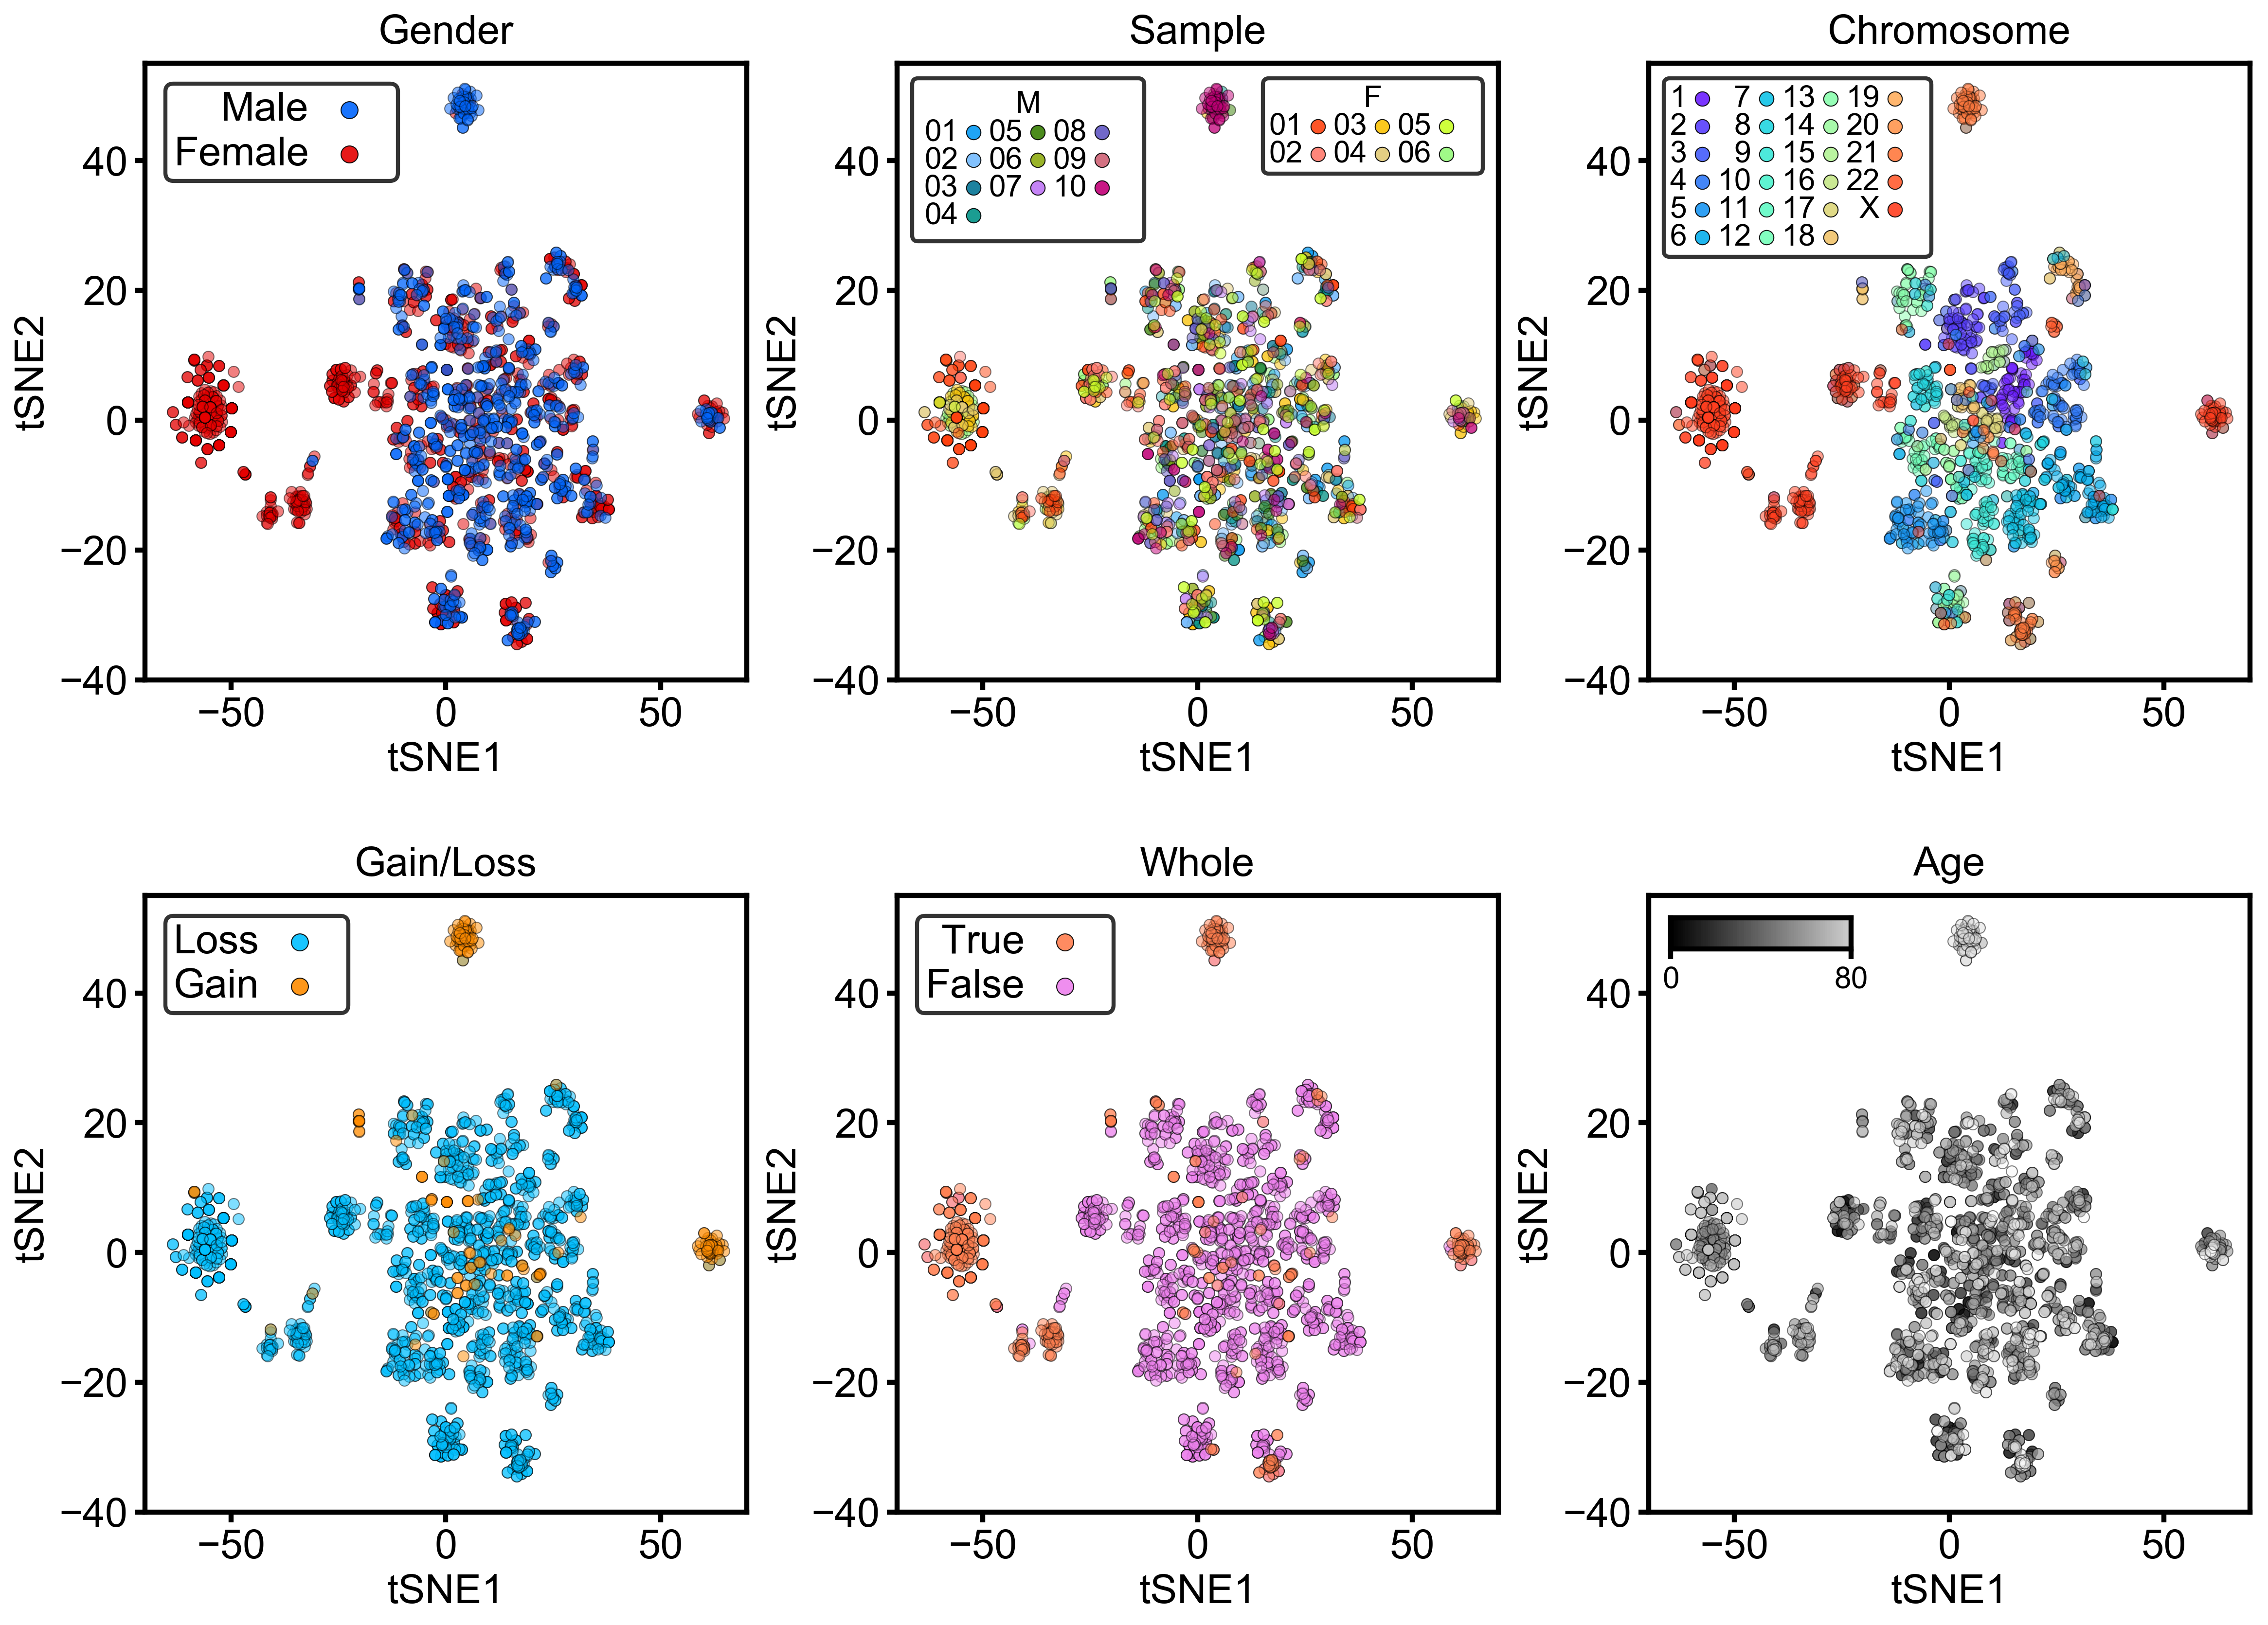

In [15]:

a4f = 2.5
width_a4f = 0.9
hight_a4f = 0.45

fig, axs = plt.subplots(
    ncols=3, nrows=2, 
    figsize=(a4f*width_a4f*8.27, a4f*hight_a4f*11.69), 
#     sharex=True, sharey=True, 
    gridspec_kw={'hspace':0.35, 'wspace':0.25},
    dpi=300
)

axs = axs.flatten()

for n,tag in enumerate(['Gender', 'Sample', 'Chromosome', 'cnvTag', 'Whole', 'Age']):

    for g,df in matrix_2d.groupby(tag):
        if g in [ 'Gain', True, 'chr21', 'chrX' ]:
            z = 10
        else:
            z = 1
        axs[n].scatter(
            df['tSNE1'],
            df['tSNE2'],
            color=matrax_colors[g],
            s=30, 
            alpha=0.5, 
            edgecolor='k', lw=0.5, 
            label=g,
            rasterized=True,
            zorder=z
        )

    if tag == 'cnvTag':
        tag = 'Gain/Loss'
    elif tag == 'Whloe':
        tag = 'Aneuploidy'
        
    axs[n].set_title(tag, y=1, va='bottom', fontsize=bigsize)
    axs[n].tick_params(axis='both', labelsize=midsize, length=5)

    axs[n].set_xlim(-70,70)
    axs[n].set_ylim(-40,55)
    axs[n].set_xlabel('tSNE1', fontsize=midsize)
    axs[n].set_ylabel('tSNE2', fontsize=midsize)


for ax in [axs[0], axs[3], axs[4]]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], 
        map(lambda x:x.capitalize(), labels[::-1]),
        loc='upper left',
        prop={'size':midsize},
        handletextpad=0,
        edgecolor='k',
        markerfirst=False,
        borderpad=0.2,
        labelspacing=0.2,
    )
    for h in ax.get_legend().legendHandles: 
        h.set_alpha(0.9)
        h.set_sizes([70])

add_sample_legend(axs[1])
add_chroms_legend(axs[2])

inset_ax = inset_axes(
    axs[5],
    loc='upper left',
    height="5%", # set height
    width="30%", # and width
)

gradient = np.linspace(-1, 82, 100)
gradient = np.vstack((gradient, gradient))

inset_ax.imshow(gradient, aspect='auto', cmap='gray')

inset_ax.set_yticks([])
inset_ax.set_xticks([0,80])
inset_ax.set_xlim(0,80)
inset_ax.tick_params(axis='x', labelsize=smallsize, length=5)

plt.show()
fig.savefig('A4_SI_tSNE.pdf', frameon=False, transparent=True, bbox_inches='tight')

---

---

In [16]:
def p_scatter1(row, ax):
    x = row['tSNE1']
    y = row['tSNE2']
    c = None
    if row['cnvTag'] == 'Loss':
        c = 'deepskyblue'
    elif row['cnvTag'] == 'Gain':
        c = 'darkorange'
    else:
        raise
    mk = None
    if row['Gender'] == 'male':
        mk = 'v'
        s = 100
    elif row['Gender'] == 'female':
        mk = 'o'
        s = 80
    else:
        raise

    ax.scatter(
        x,
        y,
        color=c,
        marker=mk,
        s=s, 
        alpha=0.7, 
        edgecolor='k', 
        lw=0.7, 
        zorder=1,
    )

    
color_dict = matrix_2d.groupby(['Chromosome','cnvTag'])['Sample'].first().reset_index()
color_dict = color_dict.assign(color=['gray'] * color_dict.shape[0]).drop('Sample', axis=1)
color_dict = color_dict.set_index(['Chromosome','cnvTag'])['color']

color_dict['chr21','Gain'] = '#FF6200'
color_dict['chr21','Loss'] = '#00BD7E'
color_dict['chrX', 'Gain'] = '#FFBF00'
color_dict['chrX', 'Loss'] = '#1CD1E4'

def p_scatter2(row, ax, whole=False):
    x = row['tSNE1']
    y = row['tSNE2']
    
    z = 1
    
    if whole and (row['chrom_fraction']<95):
        c = 'gray'
    else:
        c = color_dict[row['Chromosome'], row['cnvTag']]

    if row['Gender'] == 'male':
        mk = 'v'
        s = 100
    elif row['Gender'] == 'female':
        mk = 'o'
        s = 80
    else:
        raise

    if c == 'gray':
        z = 0

    ax.scatter(
        x,
        y,
        color=c,
        marker=mk,
        s=s, 
        alpha=0.7, 
        edgecolor='k', 
        lw=0.7, 
        zorder=z,
    )


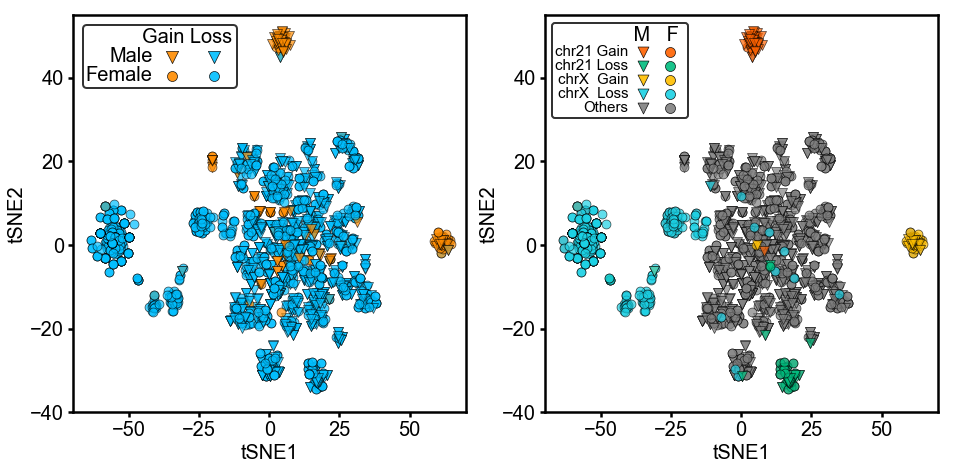

In [17]:

a4f = 2.5
width_a4f = 0.75
hight_a4f = 0.25

fig, axs = plt.subplots(
    figsize=(a4f*width_a4f*8.27, a4f*hight_a4f*11.69), 
    ncols=2,
)

_ = matrix_2d.apply(lambda row:p_scatter1(row,axs[0]), axis=1)

ax = axs[0]
ax.scatter(1e5, 1e5, s=150, alpha=0.9, edgecolor='k', lw=0.7, color='darkorange',  marker='v',label='Male')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, edgecolor='k', lw=0.7, color='darkorange',  marker='o',label='Female')
ax.scatter(1e5, 1e5, s=150, alpha=0.9, edgecolor='k', lw=0.7, color='deepskyblue', marker='v',label=' ')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, edgecolor='k', lw=0.7, color='deepskyblue', marker='o',label=' ')

handles, labels = ax.get_legend_handles_labels()

lg = ax.legend(
    handles,
    labels,
    loc='upper left',
    prop={'size':midsize},
    title=' '*10 +'Gain Loss',
    handletextpad=0,
    edgecolor='k',
    markerfirst=False,
    ncol=2,
    borderpad=0.15,
    labelspacing=0,
    columnspacing=-0.2,
)

lg.get_title().set_fontsize(midsize)

ax.set_xlim(-70,70)
ax.set_ylim(-40,55)
ax.set_xlabel('tSNE1', fontsize=midsize)
ax.set_ylabel('tSNE2', fontsize=midsize)
ax.tick_params(axis='both', labelsize=midsize, length=5)


_ = matrix_2d.apply(lambda row:p_scatter2(row,axs[1]), axis=1)
# _ = matrix_2d.apply(lambda row:p_scatter2(row,axs[1], whole=True), axis=1)

ax = axs[1]

ax.scatter(1e5, 1e5, s=120, alpha=0.9, marker='v', edgecolor='k', lw=0.7, color='#FF6200', label='chr21 Gain')
ax.scatter(1e5, 1e5, s=120, alpha=0.9, marker='v', edgecolor='k', lw=0.7, color='#00BD7E', label='chr21 Loss')
ax.scatter(1e5, 1e5, s=120, alpha=0.9, marker='v', edgecolor='k', lw=0.7, color='#FFBF00', label='chrX  Gain')
ax.scatter(1e5, 1e5, s=120, alpha=0.9, marker='v', edgecolor='k', lw=0.7, color='#1CD1E4', label='chrX  Loss')
ax.scatter(1e5, 1e5, s=120, alpha=0.9, marker='v', edgecolor='k', lw=0.7, color='gray',    label='Others')

ax.scatter(1e5, 1e5, s=100, alpha=0.9, marker='o', edgecolor='k', lw=0.7, color='#FF6200', label=' ')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, marker='o', edgecolor='k', lw=0.7, color='#00BD7E', label=' ')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, marker='o', edgecolor='k', lw=0.7, color='#FFBF00', label=' ')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, marker='o', edgecolor='k', lw=0.7, color='#1CD1E4', label=' ')
ax.scatter(1e5, 1e5, s=100, alpha=0.9, marker='o', edgecolor='k', lw=0.7, color='gray',    label=' ')

handles, labels = ax.get_legend_handles_labels()

lg = ax.legend(
    handles, labels,
    ncol=2,
    loc='upper left',
    prop={'size':smallsize},
    title=' '*13+'M' + ' '*3 + 'F',
    handletextpad=0,
    edgecolor='k',
    markerfirst=False,
    borderpad=0.2,
    labelspacing=0,
    columnspacing=-0.5,
)

lg.get_title().set_fontsize(midsize)

ax.set_xlim(-70,70)
ax.set_ylim(-40,55)
ax.set_xlabel('tSNE1', fontsize=midsize)
ax.set_ylabel('tSNE2', fontsize=midsize)
ax.tick_params(axis='both', labelsize=midsize, length=5)

plt.show()
# fig.savefig('A4_tSNE.pdf', frameon=False, transparent=True, bbox_inches='tight')
fig.savefig('A4_tSNE.svg', frameon=False, transparent=True, bbox_inches='tight')

---